## Gather insights from the provided dataset and develop a simple predictive model to   forecast the volume of flu cases.
<br>

<dl>
<dt></dt>

<dt>Syed Mehedi Hasan</dt>
 <dd>syedmehedi@yahoo.com</dd>  
 </dl>
    
### This a public dataset from the depart of health in Australia from 2008 - 2017. Further information can be found on   <a href="http://www9.health.gov.au/cda/source/pub_influ.cfm">Influenza Public dataset</a>    




In [1]:
#Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm


In [2]:
#Read data from execl file replace listed test as Na Values, omit the first row from excel
df = pd.read_excel("Influenza.xlsx", skiprows=1, na_values=["not available","Unknown"])
df.head()

,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype
0,2018-01-05,NSW,00-04,Female,NaN,B
1,2018-01-05,NSW,00-04,Female,NaN,B
2,2018-01-05,NSW,00-04,Male,NaN,A(unsubtyped)
3,2018-01-05,NSW,20-24,Male,NaN,B
4,2018-01-05,NSW,25-29,Male,NaN,A(unsubtyped)


In [3]:
print(df.count())

Week Ending (Friday)    681254
State                   681254
Age  group              681019
Sex                     678647
Indigenous status       147378
Type/Subtype            681254
dtype: int64


### Feature Engineering

In [4]:
#Change column names
df.columns = ['WeekEnding', 'State', 'AgeGroup','Sex','IndigenousStatus','Type_Subtype'] 
print(df.dtypes)
## Add a columns flues. It is 1 in each observation.
df.WeekEnding = pd.to_datetime(df.WeekEnding)
df['flues']=1

WeekEnding          datetime64[ns]
State                       object
AgeGroup                    object
Sex                         object
IndigenousStatus            object
Type_Subtype                object
dtype: object


In [5]:
df_group=df.groupby(["WeekEnding", "State","AgeGroup","IndigenousStatus","Type_Subtype"], as_index=False)["flues"].count()

In [6]:
sorted_df = df_group.sort_values(by='flues',ascending=False)
sorted_df.head()


,WeekEnding,State,AgeGroup,IndigenousStatus,Type_Subtype,flues
2723,2009-07-24,Qld,10-14,non-Indigenous,A(H1N1)pdm09,294
35255,2017-08-18,Qld,00-04,non-Indigenous,A(unsubtyped),265
2730,2009-07-24,Qld,15-19,non-Indigenous,A(H1N1)pdm09,256
35045,2017-08-11,Qld,00-04,non-Indigenous,A(unsubtyped),245
35963,2017-09-08,Qld,00-04,non-Indigenous,A(unsubtyped),242


## Insights Task:
Below are some key questions that we need you to answer but you can add more findings of your own into the presentation: 
#### 1.	What can you tell us about this dataset?
(hints: summary statistics, distribution, seasonality) 
#### 2.	Which state and age group has the most flu cases over the years and did the trend change?
#### 3.	Which flu type or subtype is most serious in Australia? 
(hint: should consider if this changed over the years)
#### 4	Does female and male get affected by flu differently?
(hints: statistical hypothesis testing)
#### 5.	Is state, sex, indigenous status or age a driver for flu?


In [7]:
dup=df.duplicated()
dup.sum()

534099

In [8]:
print(df.shape)
df.info()

(681254, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681254 entries, 0 to 681253
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   WeekEnding        681254 non-null  datetime64[ns]
 1   State             681254 non-null  object        
 2   AgeGroup          681019 non-null  object        
 3   Sex               678647 non-null  object        
 4   IndigenousStatus  147378 non-null  object        
 5   Type_Subtype      681254 non-null  object        
 6   flues             681254 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 36.4+ MB


In [9]:
## count of missing values column wise'''
df.isnull().sum()

WeekEnding               0
State                    0
AgeGroup               235
Sex                   2607
IndigenousStatus    533876
Type_Subtype             0
flues                    0
dtype: int64

In [10]:
#Change column names
df.columns = ['WeekEnding', 'State', 'AgeGroup','Sex','IndigenousStatus','Type_Subtype','flues']
df_Non_Idx=df.copy()
print(df.dtypes)
df.columns

WeekEnding          datetime64[ns]
State                       object
AgeGroup                    object
Sex                         object
IndigenousStatus            object
Type_Subtype                object
flues                        int64
dtype: object


Index(['WeekEnding', 'State', 'AgeGroup', 'Sex', 'IndigenousStatus',
       'Type_Subtype', 'flues'],
      dtype='object')

In [11]:
#Remove Sex='X' as outlier
df_Sex=df[(df['Sex']!='X')]


Text(0, 0.5, 'Total Number of Flu cases in male and female')

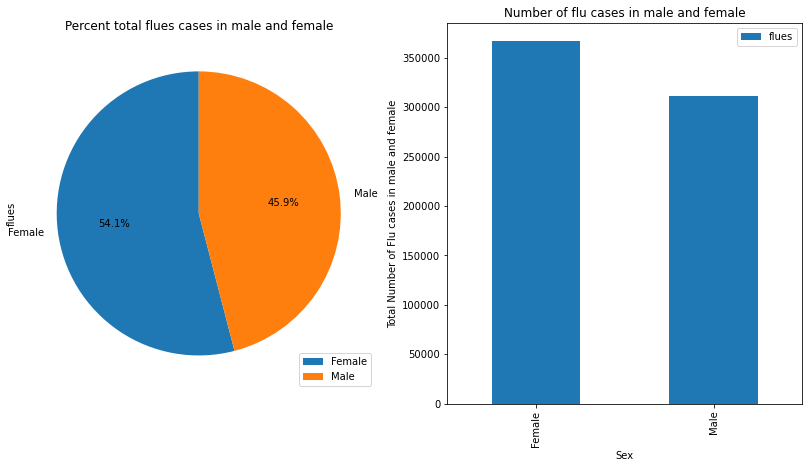

In [12]:
#group by sex to get number of flue cases by male and female
df_Sex_Count=df_Sex[['Sex','flues']].groupby(['Sex']).count()

fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

df_Sex_Count.plot(kind='pie', y='flues',title='Percent total flues cases in male and female', ax=ax1, autopct='%1.1f%%', startangle=90)
plt.ylabel("Percent total flues cases in male and female")
df_Sex_Count.plot(kind='bar',title='Number of flu cases in male and female',  ax=ax2)
plt.ylabel("Total Number of Flu cases in male and female")

In [13]:
df['Type_Subtype'].value_counts()
print(df['IndigenousStatus'].value_counts())
print(df['Sex'].value_counts())
print(df['State'].value_counts())
print(df['AgeGroup'].value_counts())

non-Indigenous    130120
Indigenous         17258
Name: IndigenousStatus, dtype: int64
Female    366829
Male      311814
X              4
Name: Sex, dtype: int64
NSW    229134
Qld    183288
Vic    113634
SA      94399
WA      42734
Tas     10226
NT       7839
Name: State, dtype: int64
00-04    75022
05-09    72857
10-14    47760
15-19    42106
35-39    41661
30-34    40189
40-44    39578
45-49    36257
25-29    35323
20-24    34609
50-54    34339
55-59    33367
60-64    30081
85+      29302
65-69    26014
70-74    22328
75-79    20962
80-84    19264
Name: AgeGroup, dtype: int64


### Distribution of Number of flues over the year in each year seperately

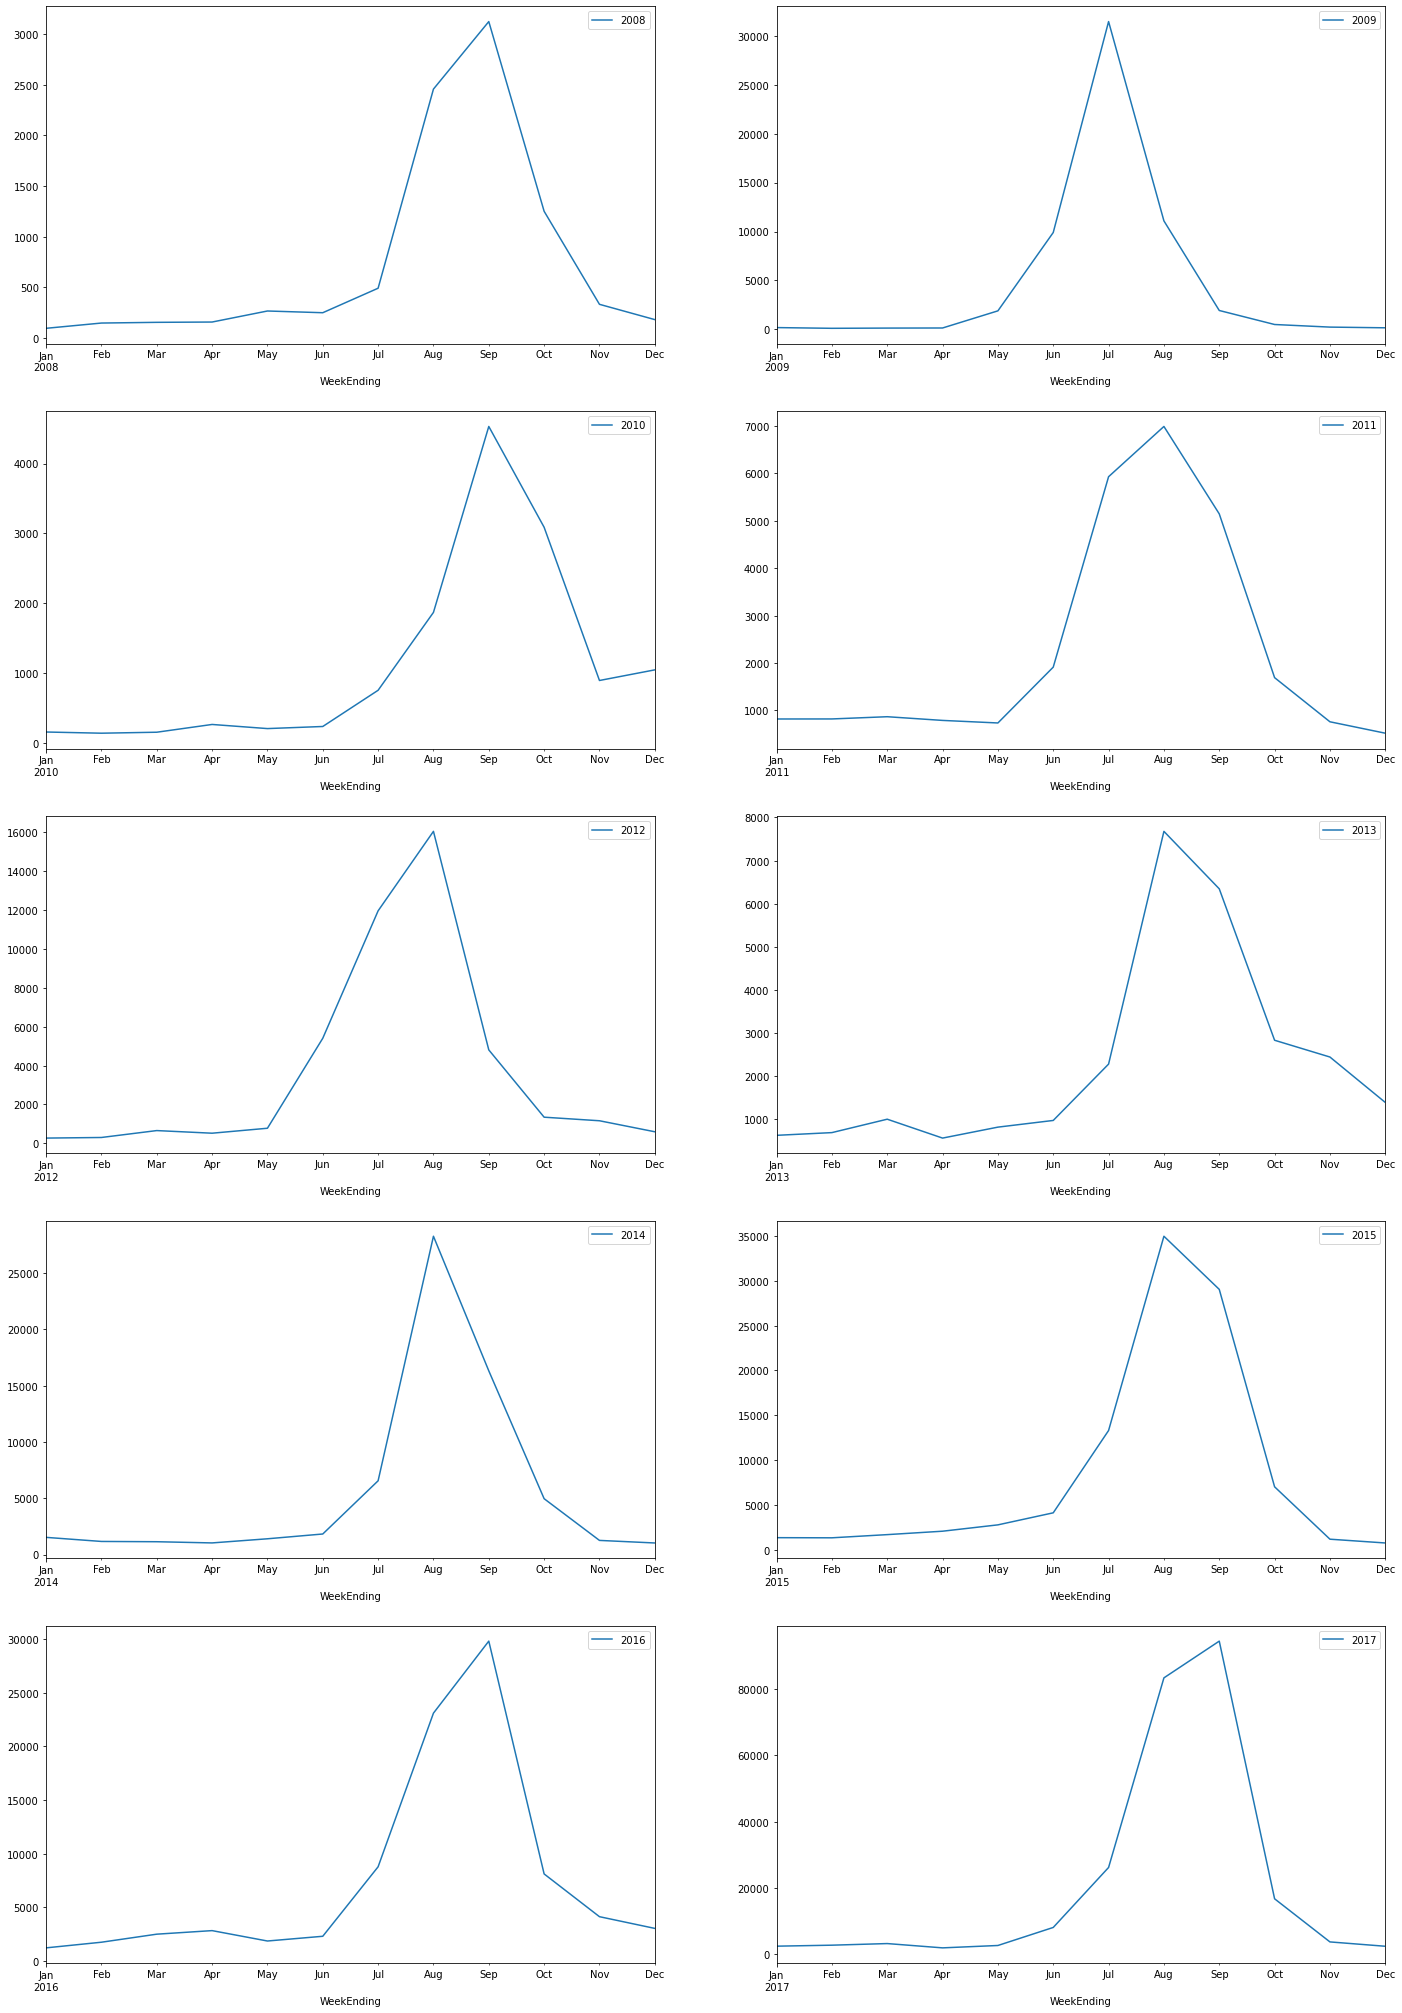

In [14]:
df_list=[]

for _year in range(2008, 2018):
    
    mask = df['WeekEnding'].dt.year == int(_year)
    tmp = df[mask]
    tmp.set_index('WeekEnding', inplace=True)
    #tmp_df=df[(df['AgeGroup']==age_group)]
    tmp_df=tmp.resample('MS').sum()
    tmp_df.columns=[str(_year)]
    df_list.append(tmp_df)
    
#define number of rows and columns for subplots
nrow=5
ncol=2
fig, axes = plt.subplots(nrow, ncol,figsize=(24,36))
# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c])
        count +=1


In [15]:
#print(df.head())
df_flues=df[['WeekEnding','flues']]
df.set_index('WeekEnding', inplace=True)

## Calculate monthly flues cases for all over Australia

In [16]:
df_TS_Flues=df.resample('MS').sum()
df_TS_Flues.head()

,flues
WeekEnding,
2008-01-01,95
2008-02-01,147
2008-03-01,154
2008-04-01,157
2008-05-01,266


In [17]:
df_TS_Flues.describe()

,flues
count,121.000000
mean,5630.198347
std,12969.117927
min,95.000000
25%,657.000000
50%,1522.000000
75%,4107.000000
max,94450.000000


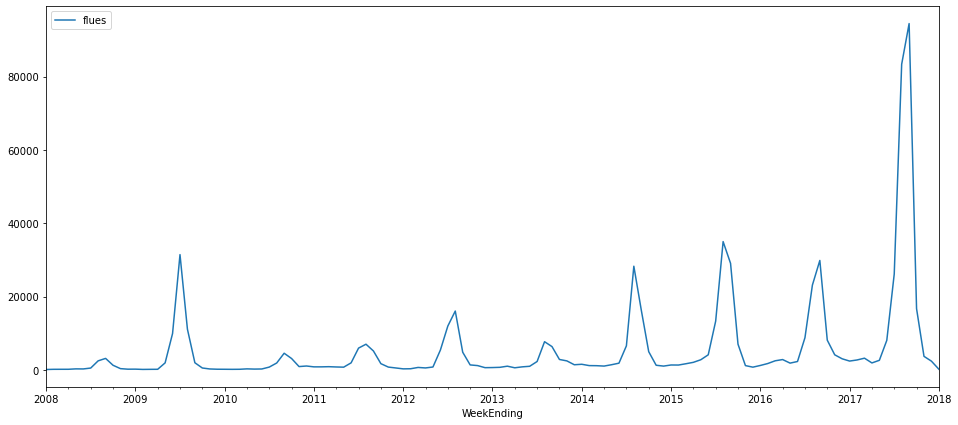

In [18]:
df_TS_Flues.plot(figsize=(16,7))
plt.show()

Text(0, 0.5, 'Total Number of Flu cases')

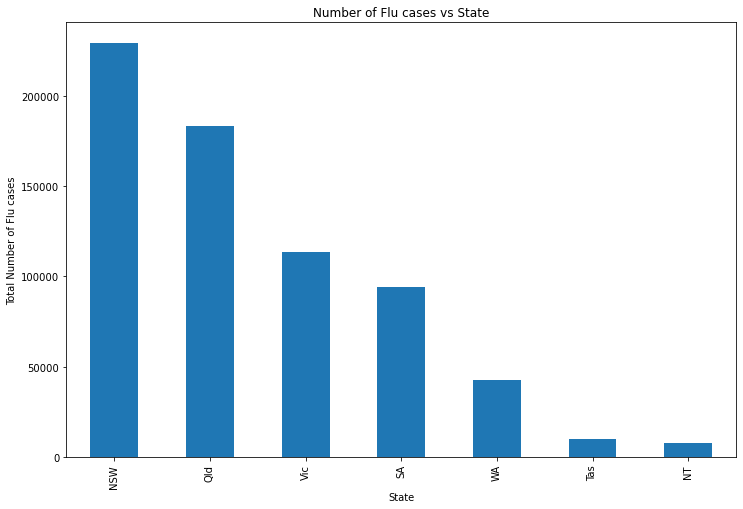

In [19]:
#group by state to get number of flue cases by each individual state
sums = df.State.groupby(df.State).count()
sums.sort_values(ascending=False).plot(kind="bar",title="Number of Flu cases vs State", figsize=(12,8))
plt.ylabel("Total Number of Flu cases")


### 2. Which state and age group has the most flu cases over the years and did the trend change?

#### Flues in individual State over the year

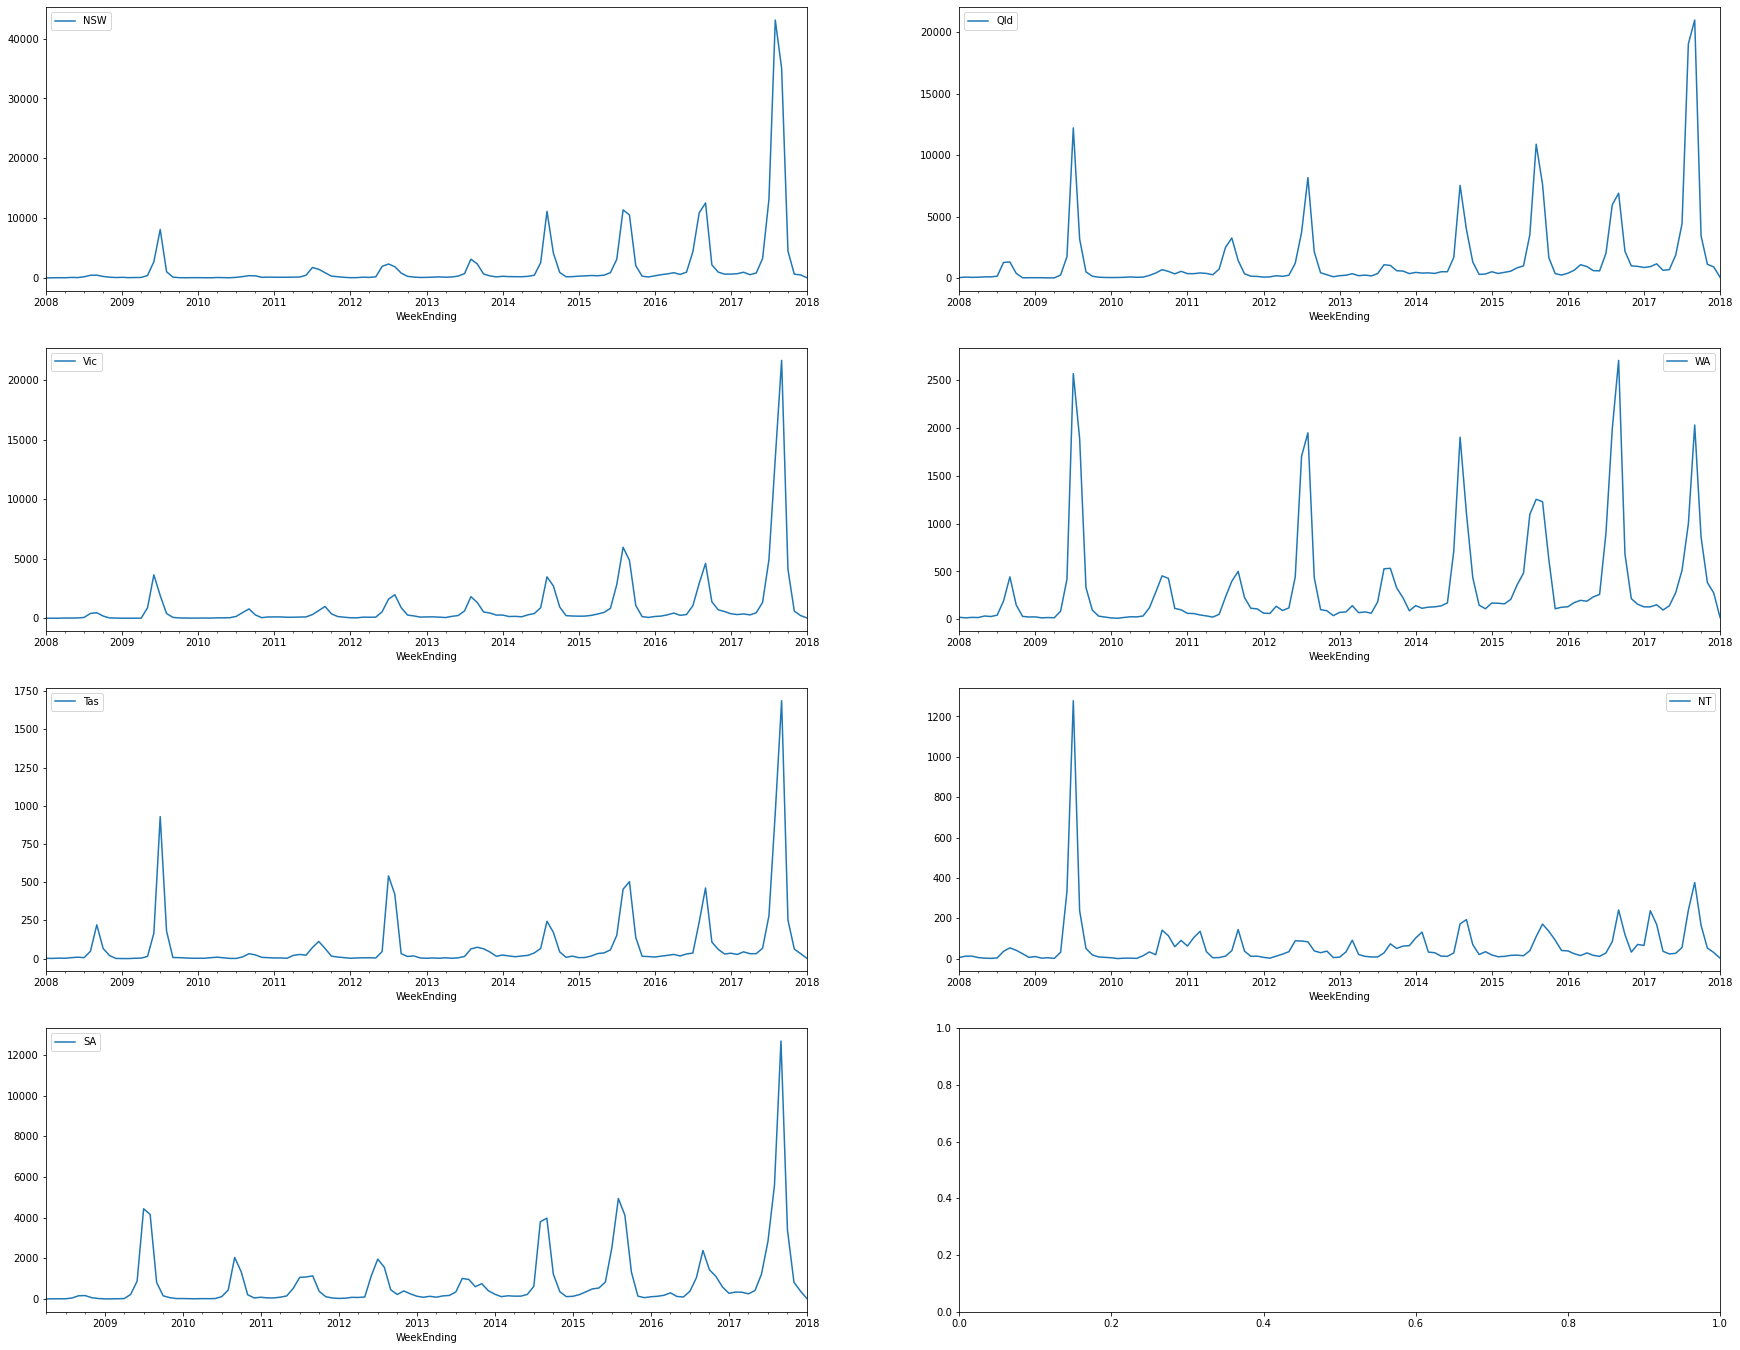

In [20]:
list_states=['NSW','Qld','Vic','WA','Tas','NT','SA']

df_states=[]

for _state in list_states:
    
    tmp=df[(df['State']==_state)]
    tmp_df=tmp.resample('MS').sum()
    
    tmp_df.columns=[_state]
    df_states.append(tmp_df)
    
#define number of rows and columns for subplots
nrow=4
ncol=2
fig, axes = plt.subplots(nrow, ncol,figsize=(30,24))
# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        if count<len(list_states):
            
            df_states[count].plot(ax=axes[r,c])
        count +=1
        



#### We can see that trend of flu cases in all over Australia and Individual state is more or less same. It is seasonal, peak after every 12 months periad and peak in  mainly (July-September) each year.

### Flues in all  Age group over the year

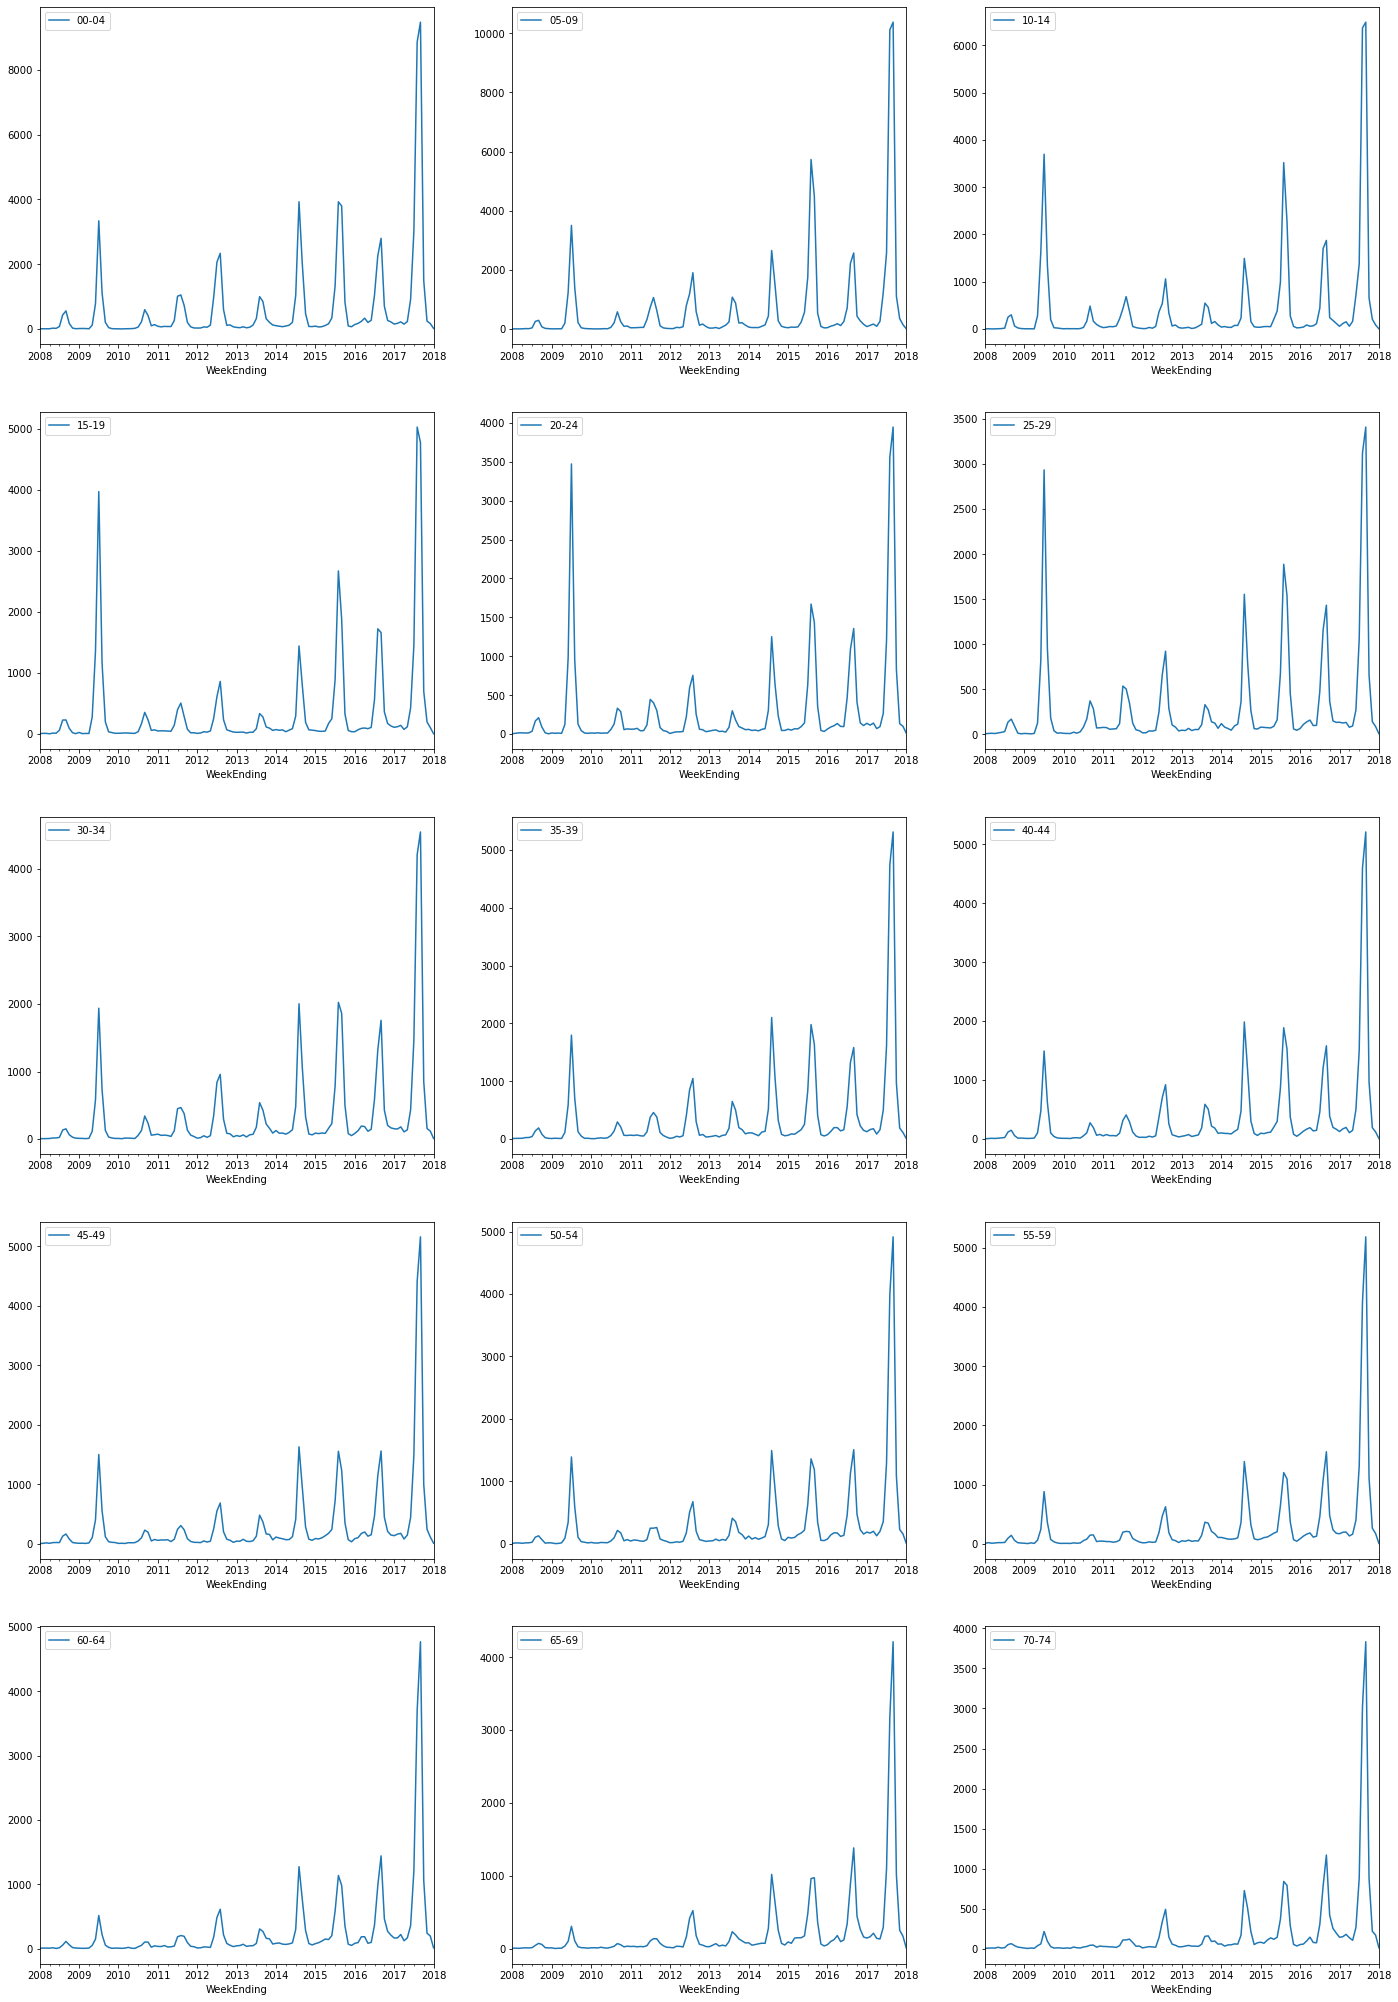

In [21]:
Age_groups=['00-04','05-09','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49',
            '50-54','55-59','60-64','65-69','70-74','75-79','80-84','85+']

df_list=[]

for age_group in Age_groups:
    
    tmp_df=df[(df['AgeGroup']==age_group)]
    tmp_df=tmp_df.resample('MS').sum()
    tmp_df.columns=[age_group]
    df_list.append(tmp_df)
    
#define number of rows and columns for subplots
nrow=5
ncol=3
fig, axes = plt.subplots(nrow, ncol,figsize=(24,36))
# plot counter
count=0
for r in range(nrow):
    for c in range(ncol):
        df_list[count].plot(ax=axes[r,c])
        count +=1


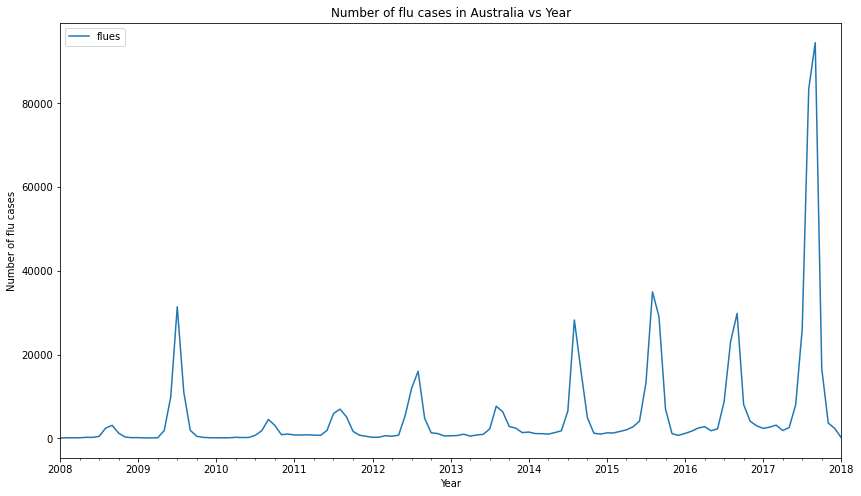

In [22]:

df_TS_Flues.plot(figsize=(14,8), title="Number of flu cases in Australia vs Year")
plt.xlabel("Year")
plt.ylabel("Number of flu cases")
plt.show()
plt.show()

Text(0, 0.5, 'Total Number of flu cases')

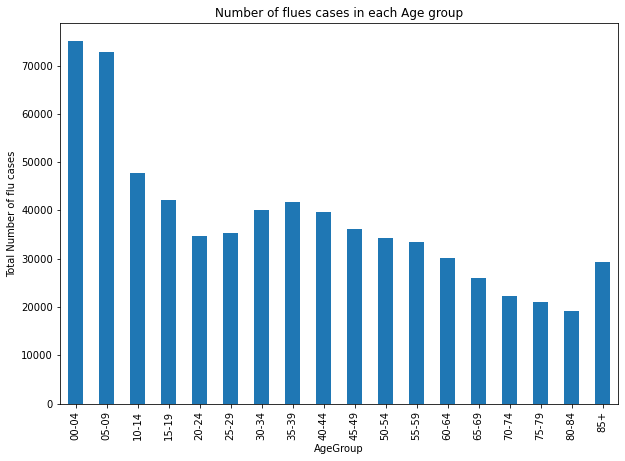

In [23]:
sums_Age_Group = df.AgeGroup.groupby(df.AgeGroup).count()
sums_Age_Group.plot(kind='bar', figsize=(10, 7),title='Number of flues cases in each Age group')
plt.ylabel("Total Number of flu cases")


Text(0.5, 0, 'Flu-Type/Sub-Type')

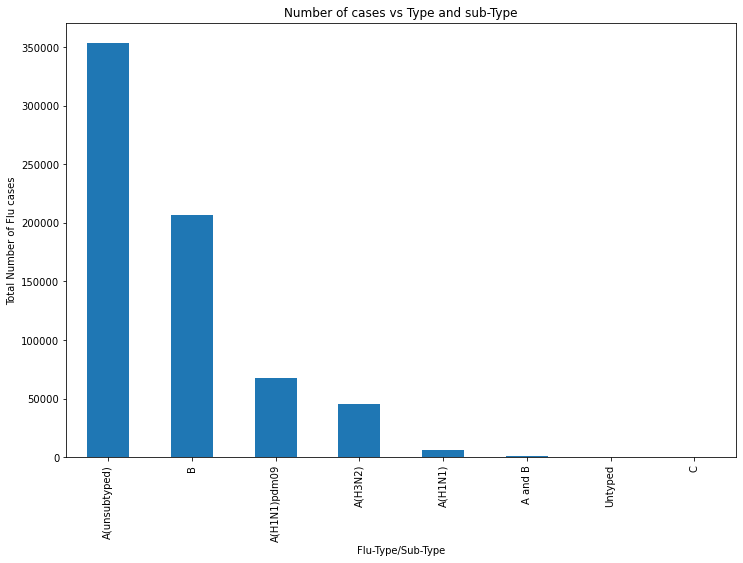

In [24]:
sums_Type_Subtype = df.Type_Subtype.groupby(df.Type_Subtype).count()
sums_Type_Subtype.sort_values(ascending=False).plot(kind='bar', title='Number of cases vs Type and sub-Type', figsize=(12, 8))
plt.ylabel("Total Number of Flu cases")
plt.xlabel("Flu-Type/Sub-Type")

## Insights Task:
## 1. (iii) Which flu type or subtype is most serious in Australia? 
### (hint: should consider if this changed over the years)


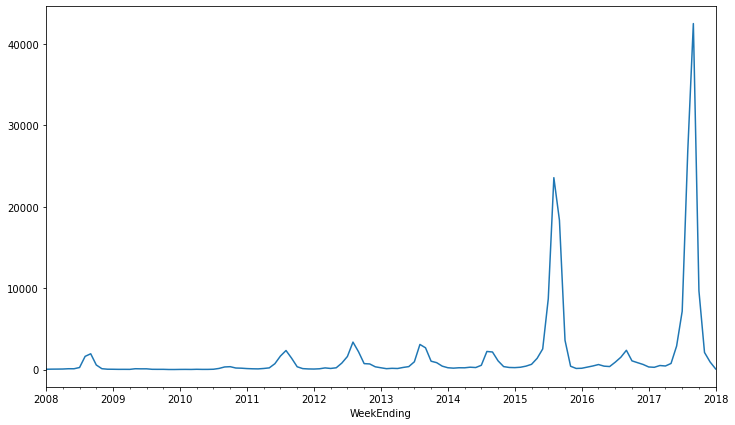

In [25]:
df_Type_B=df['Type_Subtype']=='B'
df_Type_B=df_Type_B.resample('MS').sum()
df_Type_B.head()
df_Type_B.plot(figsize=(12,7))

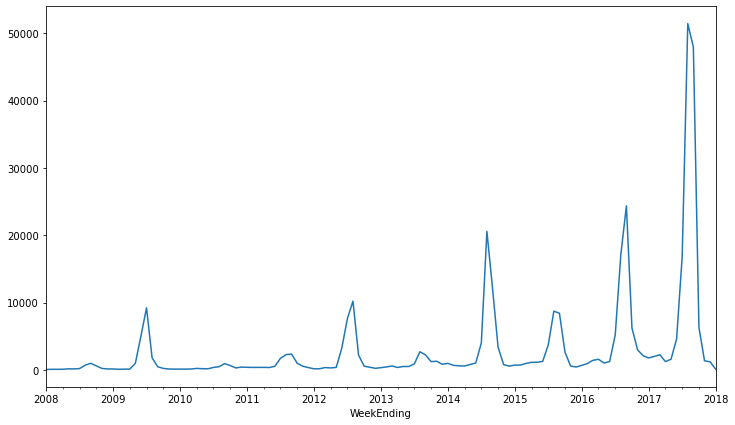

In [26]:
df_Type_A_Untyped=df['Type_Subtype']=='A(unsubtyped)'
df_Type_A_Untyped=df_Type_A_Untyped.resample('MS').sum()
df_Type_A_Untyped.head()
df_Type_A_Untyped.plot(figsize=(12,7))

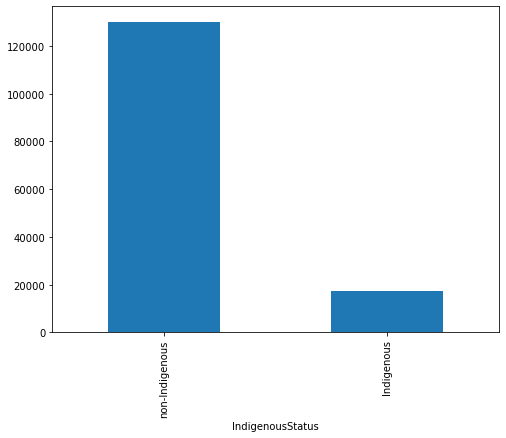

In [27]:
import matplotlib.pyplot as plt
sums_Indigenous = df.IndigenousStatus.groupby(df.IndigenousStatus).count()
#sums_Indigenous.plot.pie(figsize=(6, 6), autopct='%1.1f%%', startangle=90)
sums_Indigenous.sort_values(ascending=False).plot(kind="bar", figsize=(8, 6))

### 4 Does female and male get affected by flu differently?
#### (hints: statistical hypothesis testing)

##### #Ho: Our null hypothesis is that the proportion of Male and Female are same. Both affected equally in flues.
##### #Ha: There is a diffience between Male and Female affected by flues


In [28]:

sample_size = 5000 # get data from population or sample
significance = 0.025

sample=df['Sex'].sample(n=sample_size, random_state=1)
sample_df=sample.to_frame()
mf=sample_df.Sex.value_counts()
number_males=len(sample_df[(sample_df['Sex']=='Male')])
number_females=len(sample_df[(sample_df['Sex']=='Female')])
print('Number of Males: ' , number_males, 'Number of Females:', number_females)



Number of Males:  2335 Number of Females: 2643


In [29]:
sample_success_a, sample_size_a = (number_males, sample_size)
sample_success_b, sample_size_b = (number_females, sample_size)

#Ho: Our null hypothesis is that the proportions from the two populations are the same
#Ha: two populations are not same

# check our sample against Ho for Ha != Ho
successes = np.array([sample_success_a, sample_success_b])
samples = np.array([sample_size_a, sample_size_b])

stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
# report
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))
if p_value > significance:
    print ("Fail to reject the Null Hypothesis.")
else:
    print ("Reject the Null Hypothesis - Suggest the alternative hypothesis is true")

z_stat: -6.160, p_value: 0.000
Reject the Null Hypothesis - Suggest the alternative hypothesis is true


## 2. Modelling Task

### After Visualizing we see that data is seasonal. It shows in winter number of flu cases increase

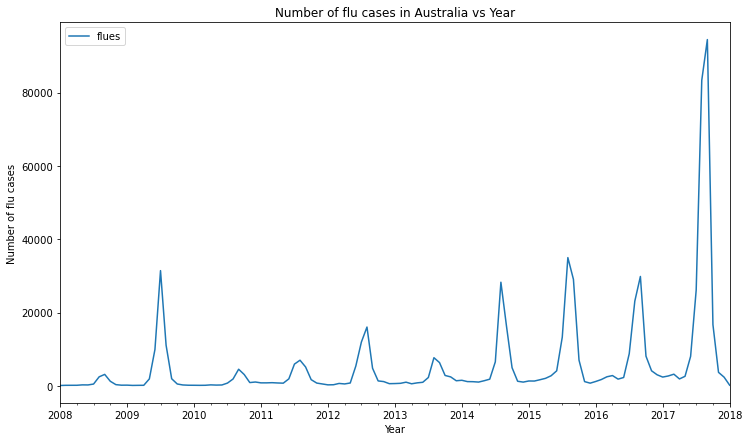

In [30]:
df_TS_Flues.plot(figsize=(12,7), title="Number of flu cases in Australia vs Year")
plt.xlabel("Year")
plt.ylabel("Number of flu cases")
plt.show()

### We must ensure that the time series is stationary. There are two primary way to determine whether a given ## time series is stationary

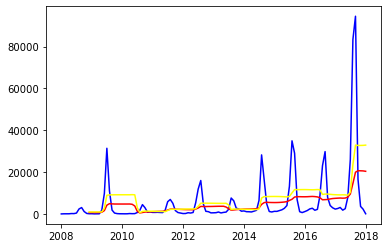

In [31]:
rolling_mean=df_TS_Flues.rolling(window=12).mean()
rolling_std=df_TS_Flues.rolling(window=12).std()
plt.plot(df_TS_Flues, color='blue', label='Original')
plt.plot(rolling_mean, color='red', label='rolling mean')
plt.plot(rolling_std, color='yellow', label='rolling STD')
plt.show()

### Testing for stationary (Another way to check stationary)

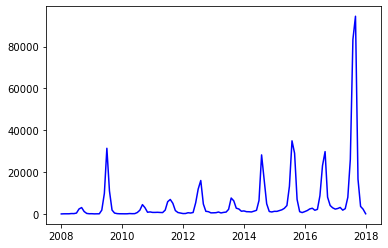

In [32]:
plt.plot(df_TS_Flues, color='blue', label='Original')

In [33]:
df_TS_Flues.head()
df_TS_Flues.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 121 entries, 2008-01-01 to 2018-01-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   flues   121 non-null    int64
dtypes: int64(1)
memory usage: 1.9 KB


In [34]:
test_results=adfuller(df_TS_Flues['flues'])


In [35]:
# H0: It is Non Stationary (Data has unique Root)
# H1: It is Stationary

def adfuller_Test(flues):
    results=adfuller(flues)
    labels=['ADF Test statistics','p Value', '%lags used', 'Number of observations used']
    
    for value,label in zip(results,labels):
        print(label + ': ' + str(value))
        
    if results[1]<=0.05:
        print('Reject Null Hypothesis. Data has no unit root and it is Stationary.')
    else:
        print('Fail to Reject Null Hypothesis. Time series has a unique root, indicates it is Non-Stationary')
        
    

In [36]:
adfuller_Test(df_TS_Flues['flues'])

ADF Test statistics: 0.35396651160596676
p Value: 0.9796893875561193
%lags used: 12
Number of observations used: 108
Fail to Reject Null Hypothesis. Time series has a unique root, indicates it is Non-Stationary


### To make it stationary we will use Differencing :

In [37]:
df_TS=df_TS_Flues
df_TS['Flues_First_Difference']=df_TS['flues']-df_TS['flues'].shift(1)

df_TS['Seasonal_First_Difference']=df_TS['flues']-df_TS['flues'].shift(12)
df_TS.head(20)

,flues,Flues_First_Difference,Seasonal_First_Difference
WeekEnding,,,
2008-01-01,95,NaN,NaN
2008-02-01,147,52.0,NaN
2008-03-01,154,7.0,NaN
2008-04-01,157,3.0,NaN
2008-05-01,266,109.0,NaN
2008-06-01,249,-17.0,NaN
2008-07-01,491,242.0,NaN
2008-08-01,2458,1967.0,NaN
2008-09-01,3125,667.0,NaN


In [38]:
adfuller_Test(df_TS_Flues['Seasonal_First_Difference'].dropna())

ADF Test statistics: -4.758707795149594
p Value: 6.519079589832764e-05
%lags used: 2
Number of observations used: 106
Reject Null Hypothesis. Data has no unit root and it is Stationary.


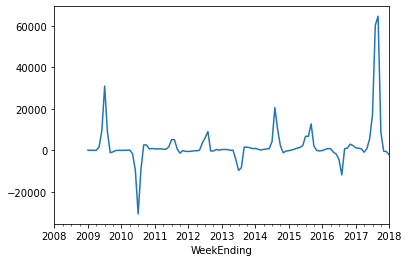

In [39]:
df_TS_Flues['Seasonal_First_Difference'].plot()

## Auto Regressive Model

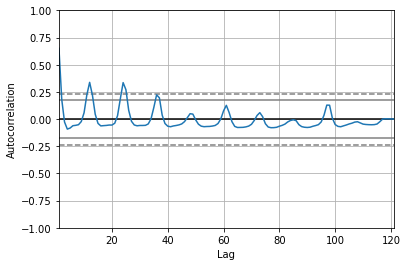

In [40]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_TS['flues'])
#autocorrelation_plot(df_TS['flues'].diff(12).dropna())
plt.show()

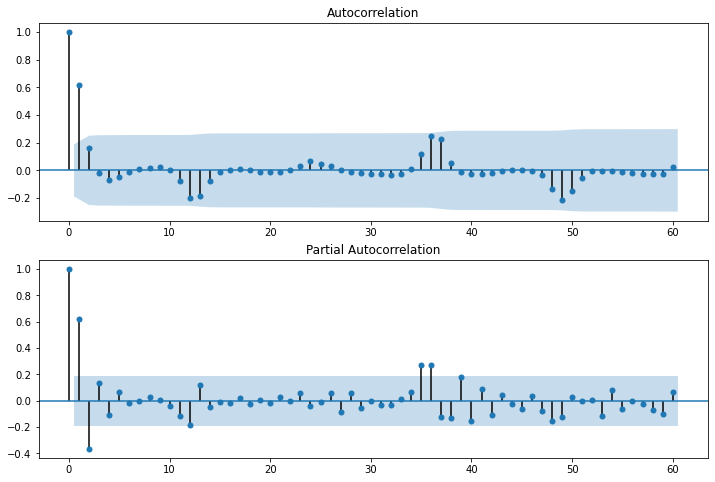

In [41]:
fig=plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)

fig=sm.graphics.tsa.plot_acf(df_TS['Seasonal_First_Difference'].iloc[13:], lags=60, ax=ax1)
ax2=fig.add_subplot(212)             
fig=sm.graphics.tsa.plot_pacf(df_TS['Seasonal_First_Difference'].iloc[13:], lags=60, ax=ax2)   


### As Data has Seasonality, we use shall use here Seasonal-ARIMA (SARIMA): 

In [42]:
## For Seansonal Data
import statsmodels.api as sm
model_s=sm.tsa.statespace.SARIMAX(df_TS['flues'],order=(0,0,2),seasonal_order=(1,1,0,12))

results=model_s.fit()


In [43]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               flues   No. Observations:                  121
Model:             SARIMAX(0, 0, 2)x(1, 1, [], 12)   Log Likelihood               -1122.641
Date:                             Mon, 31 Aug 2020   AIC                           2253.282
Time:                                     23:27:12   BIC                           2264.047
Sample:                                 01-01-2008   HQIC                          2257.647
                                      - 01-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.8793      0.047     18.784      0.000       0.788       0.971
ma.L2          0.2524      0.059      4.267      0.000       0.136       0.368
ar.S.L12      -0.4190      0.085     -4.941      0.000      -0.585      -0.253
sigma2      5.232e+07   1.43e-09   3.65e+16      0.000    5.23e+07    5.23e+07
===================================================================================
Ljung-Box (Q):                       17.05   Jarque-Bera (JB):               882.75
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.40   Skew:                             2.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.86e+30. Standard errors may be unstable.
"""

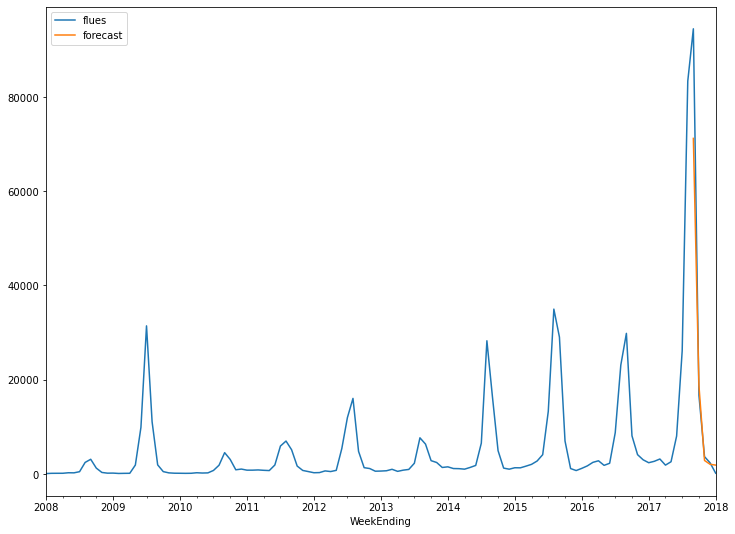

In [44]:
start=116
end=121

test_flues=  df_TS.iloc[start:]

predictions_test=results.predict(start=start, end=end,dynamic=True)

df_TS['forecast']=results.predict(start=start, end=end,dynamic=True)

df_TS[['flues','forecast']].plot(figsize=(12,9))

In [45]:
test_flues.head()

df_Test_Pred=test_flues['flues']
df_Test_Pred=df_Test_Pred.to_frame()
df_Test_Pred.columns=['Actual']
df_Test_Pred.head(),df_Test_Pred.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5 entries, 2017-09-01 to 2018-01-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Actual  5 non-null      int64
dtypes: int64(1)
memory usage: 80.0 bytes


(            Actual
 WeekEnding        
 2017-09-01   94450
 2017-10-01   16695
 2017-11-01    3682
 2017-12-01    2371
 2018-01-01     172,
 None)

In [46]:
predictions_test=predictions_test.to_frame()
predictions_test.columns=['Predicted']




,Actual Flues,Predicted Flues
count,5.000000,5.000000
mean,23474.000000,19360.437392
std,40198.229109,29849.821095
min,172.000000,1893.236605
25%,2371.000000,2059.168520
50%,3682.000000,2871.039988
75%,16695.000000,18778.442146
max,94450.000000,71200.299704


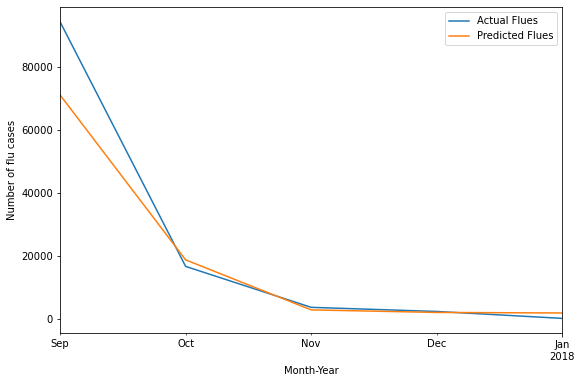

In [47]:
df_Test_Pred['Prediction']=predictions_test['Predicted']
df_Test_Pred.columns=['Actual Flues','Predicted Flues']
df_Test_Pred.plot(figsize=(9,6))
plt.xlabel("Month-Year")
plt.ylabel("Number of flu cases")
df_Test_Pred.describe()

In [48]:
test_data=df_Test_Pred['Actual Flues']
predict_data=df_Test_Pred['Predicted Flues']

RMSE=rmse(test_data, predict_data) 
  
# Calculate mean squared error 
MAE=mean_squared_error(test_data, predict_data) 

r2 = r2_score(test_data, predict_data) 

print('RMSE: ', RMSE,'MAE:', MAE, "R-Square: ", r2)

RMSE:  10474.796852472462 MAE: 109721369.10056698 R-Square:  0.9151235143977494


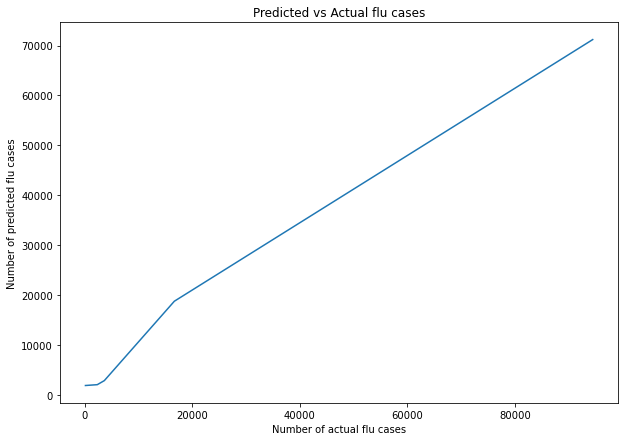

In [49]:
plt.figure(figsize=(10,7))
plt.plot(test_data,predict_data)
plt.xlabel("Number of actual flu cases")
plt.ylabel("Number of predicted flu cases")
plt.title("Predicted vs Actual flu cases")
plt.show()


## Future Forcast (6 or 24 Months)

In [50]:
df_TS=df_TS_Flues
#Number of future months to forecast
future_months=12
from pandas.tseries.offsets import DateOffset
future_dates=[df_TS.index[-1] + DateOffset(months=x) for x in range(0,future_months)]
future_dates_df=pd.DataFrame(index=future_dates[1:], columns=df_TS.columns)


In [51]:
future_df=pd.concat([df_TS,future_dates_df])


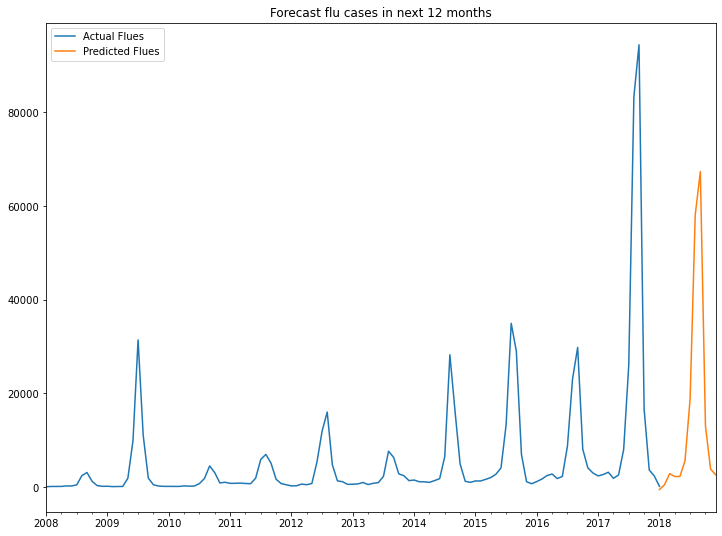

In [52]:
# future forcast

future_df['forecast']=results.predict(start=len(df_TS)-1, end=len(df_TS) + future_months, dynamic=True)

df_forcast=future_df[['flues','forecast']].copy()
df_forcast.columns=['Actual Flues','Predicted Flues']
df_forcast.plot(figsize=(12,9),title='Forecast flu cases in next 12 months',)


### FIND BEST Parameter (p,d,q)(P,D,Q)S for SARIMA

In [53]:
'''
import itertools
p = range(0, 5)
d = range(1,3)
q = range(0, 5)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
seasonal_pdq

## to get best Paramter p,d,q

ts_s_adj=df_TS['flues']
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_s_adj,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            )
            results = mod.fit(method = 'powell')
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
'''

"\nimport itertools\np = range(0, 5)\nd = range(1,3)\nq = range(0, 5)\npdq = list(itertools.product(p, d, q))\nseasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]\nprint('Examples of parameter combinations for Seasonal ARIMA...')\nprint('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))\nprint('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))\nprint('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))\nseasonal_pdq\n\n## to get best Paramter p,d,q\n\nts_s_adj=df_TS['flues']\nfor param in pdq:\n    for param_seasonal in seasonal_pdq:\n        try:\n            mod = sm.tsa.statespace.SARIMAX(ts_s_adj,\n                                            order=param,\n                                            seasonal_order=param_seasonal,\n                                            )\n            results = mod.fit(method = 'powell')\n            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))\n        except:\n            continue\n"

## Train Test Split and SARIMA EVALUATION

In [54]:

df_FL=df_TS
num_months=30
#ARIMA(0, 2, 4)x(2, 2, 2, 12)12 - AIC:1959.1572008629114 Best R_square 0.818
#Best model:  ARIMA(0,0,2)(1,1,0)[12] 

In [55]:
# Split data into train / test sets 
train = df_FL.iloc[:len(df_FL)-num_months] 
test =  df_FL.iloc[len(df_FL)-num_months:] # set one year(12 months) for testing 
  
# Fit a SARIMAX(0, 1, 1)x(2, 1, 1, 12) on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
train= train['flues'] #df_FL['flues']
model = SARIMAX(df_FL['flues'],  
                order = (0, 2, 4),  
                seasonal_order =(2, 2, 2, 12)) 
  
result = model.fit() 
result.summary() 


C:\Users\syedm\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\syedm\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                   flues   No. Observations:                  121
Model:             SARIMAX(0, 2, 4)x(2, 2, [1, 2], 12)   Log Likelihood                -983.832
Date:                                 Mon, 31 Aug 2020   AIC                           1985.664
Time:                                         23:27:21   BIC                           2008.649
Sample:                                     01-01-2008   HQIC                          1994.952
                                          - 01-01-2018                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1700      0.204     -5.741      0.000      -1.569      -0.771
ma.L2         -0.2537      0.391     -0.648      0.517      -1.021       0.514
ma.L3          0.3012      0.345      0.874      0.382      -0.374       0.977
ma.L4          0.1511      0.336      0.449      0.653      -0.508       0.810
ar.S.L12      -0.9931      0.340     -2.920      0.003      -1.660      -0.327
ar.S.L24      -0.6655      0.270     -2.461      0.014      -1.196      -0.135
ma.S.L12      -0.2617      0.417     -0.628      0.530      -1.079       0.556
ma.S.L24       0.3831      0.398      0.962      0.336      -0.397       1.164
sigma2      9.133e+07   8.87e-09   1.03e+16      0.000    9.13e+07    9.13e+07
===================================================================================
Ljung-Box (Q):                       14.34   Jarque-Bera (JB):               147.33
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.95   Skew:                             0.42
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.37e+32. Standard errors may be unstable.
"""

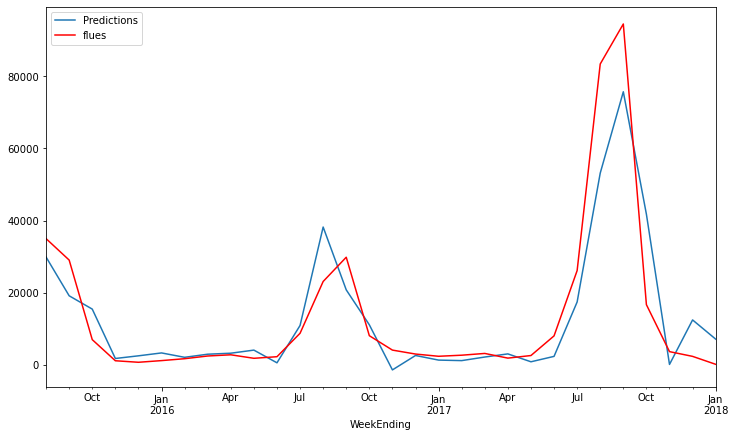

In [56]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 

predictions_all = result.predict(start=start, end=end, 
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values 
#predictions_all.plot(legend = True, figsize=(12,7)) 
predictions.plot(legend = True, figsize=(12,7)) 

test['flues'].plot(legend = True, figsize=(12,7),color='red') 
#train['flues'].plot(legend = True, figsize=(12,7)) 
#df_FL['flues'].plot(legend = True, figsize=(12,7)) 

In [57]:
test_data=test['flues']
predict_data=predictions

# Load specific evaluation tools 
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
  
# Calculate root mean squared error 
RMSE=rmse(test_data, predict_data) 
  
# Calculate mean squared error 
MAE=mean_squared_error(test_data, predict_data) 
r2 = r2_score(test_data, predict_data) 

print('RMSE: ', RMSE,'MAE:', MAE, "R-Square: ", r2)

RMSE:  9555.414610011818 MAE: 91305948.3692273 R-Square:  0.8184602377753284


Text(0, 0.5, 'Number of flu cases')

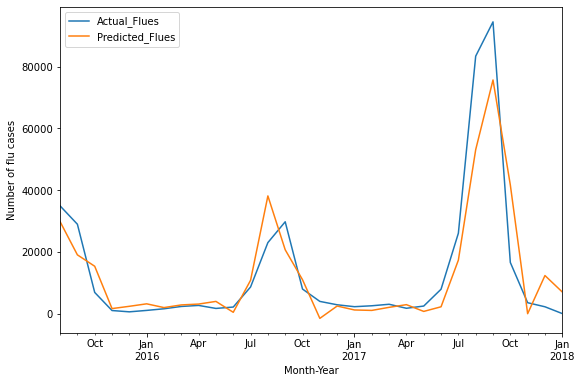

In [58]:
df_pred=test_data.to_frame()
pp=predictions.to_frame()
df_pred['Predicted_Flues']=pp['Predictions']
df_pred.columns=['Actual_Flues','Predicted_Flues']
df_pred.plot(figsize=(9,6))
plt.xlabel("Month-Year")
plt.ylabel("Number of flu cases")


In [59]:
df_pred.describe()

,Actual_Flues,Predicted_Flues
count,30.000000,30.000000
mean,13661.966667,12872.730069
std,22809.999887,18155.622608
min,172.000000,-1378.625774
25%,2301.250000,2129.042117
50%,3098.000000,3285.808054
75%,14712.750000,16949.363540
max,94450.000000,75670.636969
